# AMATH 515 Homework 3

**Due Date: 02/28/2024 at 23:59 PM PDT**

*Homework Instruction*: Please follow order of this notebook and fill in the codes where commented as `TODO`. **please submit both** `proxes.py` **and** `515Hw3_Coding.ipynb` to Gradescope. You'll have **10 attempts** to pass the tests.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Problem 5

## Please complete the code in `proxes.py`

In [2]:
import sys
sys.path.append('./')
from proxes import *

## Test cases

In [3]:
np.random.seed(124)
m = 5
n = 2
k = 1
z = np.random.randn(m, n)
x = np.zeros((m, n))

In [4]:
for i in range(m):
    x[i] = prox_csimplex(z[i], k)

In [5]:
#==GRADED==#
print(x)

[[0.87571657 0.12428343]
 [0.         1.        ]
 [0.14058588 0.85941412]
 [0.         1.        ]
 [1.         0.        ]]


If you did everything right then the projections of the points on the plot below should be sitting on the black interval that connects [0,1] and [1,0]

(-1.6232447306802724,
 1.8058687966990605,
 -0.9018258603599083,
 2.470293840568626)

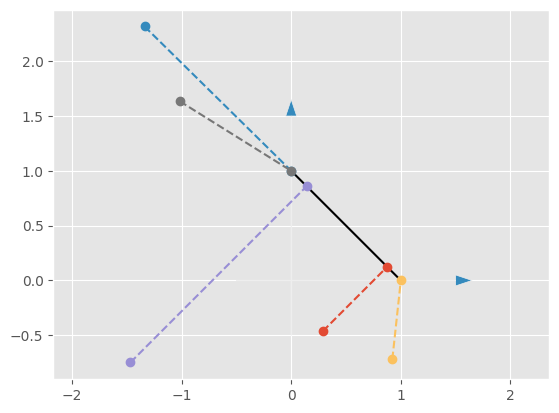

In [6]:
plt.clf()
plt.arrow(-0.5,  0.0,  2.0,  0.0, head_width=0.1)
plt.arrow( 0.0, -0.5,  0.0,  2.0, head_width=0.1)
plt.plot([0.0, 1.0], [1.0, 0.0], '-k')
for i in range(m):
    plt.plot([z[i][0], x[i][0]], [z[i][1], x[i][1]], 'o--')
plt.axis('equal')

# Problem 6

In [7]:
# Build a dataset for matrix completion
import numpy as np
import matplotlib.pyplot as plt
from solvers import optimizeWithAPGD
from proxes import prox_csimplex
from proxes import prox_l1

In [8]:
d=250
rank=5
#Only see 8% of the entries
mask_prob=0.08

gen=np.random.default_rng(seed=515)
original_matrix=gen.standard_normal(size=(d,d))

P=gen.binomial(1,mask_prob,(d,d))

U,sigma,Vt=np.linalg.svd(original_matrix)
sigma[rank:]=0
X=(U@np.diag(sigma)@Vt)
X=X/np.sqrt(np.mean(X**2))

X_observed=X*P

In [9]:
def reconstruction_loss(Y):
    """This is our out of sample reconstruction loss. Only for evaluation!
    """
    return np.mean((Y-X)**2)


def l2_loss(Y):
    return np.sum(P*((Y-X_observed)**2))/2

def l2_grad(Y):
    # TODO Write the gradient of f
    return P * (Y-X_observed)
    pass

def nuclear_norm(Y):
    return np.linalg.norm(Y,'nuc')

In [10]:
##==GRADED==##

proxes_test_matrix=np.array([
    [1,3,5],
    [2,1,4],
    [1,1,1]
])

nuclear_prox_test=nuclear_prox(proxes_test_matrix,1.5)
rank_proj_test=rank_project(proxes_test_matrix,2)

In [11]:
def apgd_nuclear_norm_completion(Y0,lam):
    Y_sol,obj_his,err_his,exit_flag=optimizeWithAPGD(
        Y0,
        l2_loss,
        lambda x:lam*nuclear_norm(x),
        l2_grad,
        lambda x,t:nuclear_prox(x,lam*t),
        beta_f=1,
        max_iter=1000,
        tol=1e-5
    )

    return Y_sol,obj_his,err_his,exit_flag

def apgd_rank_constrained_completion(Y0,k):
    Y_sol,obj_his,err_his,exit_flag=optimizeWithAPGD(
        Y0,
        l2_loss,
        lambda x:0,
        l2_grad,
        lambda x,t:rank_project(x,k),
        beta_f=1,
        max_iter=1000,
        tol=1e-5
    )
    return Y_sol,obj_his,err_his,exit_flag

## Solve an example

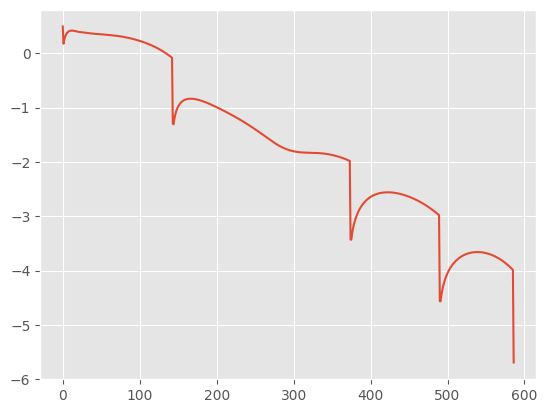

In [12]:
##==GRADED==##

#Initialize with the observed entries
Y0=X_observed.copy()
lam=0.2

nuclear_example_sol,obj_his,err_his,exit_flag=apgd_nuclear_norm_completion(Y0,lam)

# example_sol is graded here
plt.plot(np.log10(err_his))


In [13]:
print("Rank of our recovered matrix:",(np.sum(np.linalg.svd(nuclear_example_sol)[1]>1e-6)))

#This should be about 0.1
reconstruction_error=reconstruction_loss(nuclear_example_sol)
print("Reconstruction error on the full dataset:",reconstruction_error)

print("Note that the original entrywise variance is 1, \
so in some sense our recovered estimates are about 90% accurate, using only 8% of the data")

Rank of our recovered matrix: 32
Reconstruction error on the full dataset: 0.09823600446583426
Note that the original entrywise variance is 1, so in some sense our recovered estimates are about 90% accurate, using only 8% of the data


## Sweep through many values of lambda

In [15]:
lam_vals=np.append(np.arange(0.25,3,0.25)[::-1],np.array([0.1,0.05,0.01]))
##==GRADED==##
#TODO Sweep through each of values in lam_vals
#Compute the nuclear norm regularized matrix completion
#   for each value of lambda in lam_vals


Y_solution_list = []
for i in range(len(lam_vals)):
    Y_soln,obj_his,err,exit_flag = apgd_nuclear_norm_completion(Y0,lam_vals[i])
    Y_solution_list.append(Y_soln)

# Y_solution_list should be a python list of the solutions (2d array) for each regularization strength
# Y_solution_list[i] is the solution with the regularization strenght lam_vals[i]

In [ ]:
## Graded ##
nuc_parameter_sweep_solutions=np.array(Y_solution_list)

In [ ]:
plt.plot(lam_vals,[reconstruction_loss(y) for y in Y_solution_list])
plt.ylabel("Reconstruction error")
plt.xlabel("Regularization strength lambda")
plt.title("Overall Reconstruction Error")

You should find that as lambda goes to 0, the reconstruction error goes down. This is because we begin to approximate a certain semidefinite programming problem, minimizing nuclear norm subject to the observed entries being exactly correct. This problem has very good theoretical guarantees, including exact recovery under certain conditions!

See this Candes and Tao paper if you're interested: https://arxiv.org/abs/0903.1476

#### Just because the set of matrices with constrained rank isn't convex, doesn't mean that we can't try accelerated projected gradient descent on it! We warm start with the last solution generated from nuclear norm regularization. 

In [ ]:
Y_rank5,obj_his,err_his,exit_flag=apgd_rank_constrained_completion(Y_solution_list[-1],5)

plt.plot(np.log10(err_his))
nonconvex_reconstruction=reconstruction_loss(Y_rank5)
print("Rank 5 reconstruction loss:",nonconvex_reconstruction)

You should find that we have exact recovery of the original matrix X by using this non-convex constraint despite only observing 8% of the entries. I find this **truly remarkable!**